In [2]:
from __future__ import division, print_function, absolute_import
import csv
import pandas
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os
import xml.etree.ElementTree as etree
import cobra
import numpy as np
from itertools import chain
from cobra.util import solver as sutil
from cobra.core.solution import get_solution
from optlang.symbolics import add, Zero
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
from cobra.medium import minimal_medium
# Press ⌃R to execute it or replace it with your code.
# Press Double ⇧ to search everywhere for classes, files, tool windows, actions, and settings.
from cobra.flux_analysis import production_envelope
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model



In [3]:
## Pareto function
# Pareto
objective1={''}
objective2={''}
pareto_range = (0.0, 1.001)  # for some reason you need to pick a number higher than 1).
pareto_step_size = 0.01
analysis_type = 'pareto'
metric = 'manhattan'
rxn2avoid = {''}
solver='gurobi'
constants = {'deltaC_CO2': 0.0055, 'D_H2O_0': 2.13E-05, 'D_CO2_0': 1.33E-05, 'mid_day': 6, 'deltaT': 2,
             'FeasTol': 1e-03, 'OptTol': 1e-03}
def pareto_analysis(model, objective1=objective1, objective2=objective2, pareto_range=pareto_range, metric=metric):
    reaction_obj1 = model.reactions.get_by_id(objective1)
    reaction_obj2 = model.reactions.get_by_id(objective2)
    result_list = []
    model.objective = {}
    reaction_obj1.objective_coefficient = 1
    solution = model.optimize()
    print("\nSolving model (FBA) for determining objective 1 flux...")
    max_obj1 = dict(solution.fluxes)[objective1]
    print("Max {0}: {1}".format(objective1, max_obj1))
    # change objective
    reaction_obj1.objective_coefficient = 0
    reaction_obj2.objective_coefficient = 1
    print("\nSolving all iterations for Pareto frontier (FBA)...")
    for pareto in np.arange(pareto_range[0], pareto_range[1], pareto_step_size):
        if pareto == 1:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.999 # we need to add a bit of slack as the quadratic optimization is less accurate than the linear couterpart
        else:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.9999
        sol = model.optimize(objective_sense='maximize')
        # fix this minimal water loss value
        reaction_obj2.bounds = (sol.get_primal_by_id(objective2), sol.get_primal_by_id(objective2))
        if metric == 'manhattan':
            solution = cobra.flux_analysis.pfba(model)
            # print({'proline sink': solution['SK_PRO_c_06'], 'biomass 05': solution['Leaf_biomass_tx_05'], 'biomass 06': solution['Leaf_biomass_tx_06']})
            # solution.fluxes.to_excel(f'pareto_no_{pareto}.xlsx')
            result_list.append([pareto, solution[objective1], solution[objective2]])
            reaction_obj2.bounds = (0, 1000.0)
        elif metric == 'euclidean':

            # make copy because that is easier that reverting all the solver settings
            copy_model = model.copy()
            model.solver = solver

            FeasTol = float(constants['FeasTol'])
            OptTol = float(constants['OptTol'])

            copy_model.solver.configuration.tolerances.feasibility = FeasTol
            copy_model.solver.configuration.tolerances.optimality = OptTol

            rxnlist = [r for r in copy_model.reactions if r.id not in rxn2avoid]

            obj_vars = chain.from_iterable([r.flux_expression ** 2] for r in rxnlist)
            copy_model.objective = copy_model.problem.Objective(add(obj_vars), direction='min')

            print('\nSolving quadratic minimisation of sum of fluxes')
            #print(solver)
            solution = copy_model.optimize(objective_sense=None)
            result_list.append([pareto, solution[objective1], solution[objective2]])
        reaction_obj2.bounds = (0, 1000.0)
    return result_list

In [4]:
model = read_sbml_model('beta_day_DM_new.xml')
core_model=model
#core_model.reactions.get_by_id('Photon_tx').bounds = (0,29.96568)
sol = core_model.optimize()
print(core_model.summary(sol))

core_model.metabolites.query('ASCORBATE')
#core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_m')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-16
Objective
1.0 AraCore_Biomass_tx = 759.8992379743938

Uptake
------
      Metabolite   Reaction    Flux  C-Number  C-Flux
CARBON_DIOXIDE_e     CO2_tx   28.67         1 100.00%
          CAII_e      Ca_tx  0.2912         0   0.00%
         WATER_e     H2O_tx   24.59         0   0.00%
            KI_e       K_tx  0.5956         0   0.00%
          MGII_e      Mg_tx  0.1919         0   0.00%
       NITRATE_e Nitrate_tx   2.515         0   0.00%
        Photon_e  Photon_tx     300         0   0.00%
            Pi_e      Pi_tx  0.1166         0   0.00%
       SULFATE_e     SO4_tx 0.03596         0   0.00%

Secretion
---------
       Metabolite Reaction   Flux  C-Number C-Flux
         PROTON_e     H_tx -1.007         0  0.00%
OXYGEN_MOLECULE_e    O2_tx -35.36         0  0.00%



[<Metabolite ASCORBATE_m at 0x1823756a0>,
 <Metabolite ASCORBATE_p at 0x182377710>,
 <Metabolite L_DEHYDRO_ASCORBATE_m at 0x182374b00>,
 <Metabolite L_DEHYDRO_ASCORBATE_p at 0x181ec6cc0>,
 <Metabolite ASCORBATE_c at 0x18241cb30>]

In [5]:
##Constraints
rubisco = core_model.problem.Constraint(3 * core_model.reactions.get_by_id("RXN_961_p").flux_expression - core_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression,lb=0, ub=0,)
core_model.add_cons_vars([rubisco])
## 
atp = core_model.problem.Constraint((0.0049*core_model.reactions.get_by_id("Photon_tx").flux_expression+2.7851)-core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp)
##
atp_nadph_03 = core_model.problem.Constraint(3 * (core_model.reactions.get_by_id("NADPHoxm_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxc_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxp_tx").flux_expression) - core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp_nadph_03)

In [63]:
## biotic
#h2o2_biotic = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=0.002339457096)
#core_model.add_cons_vars(h2o2_biotic)
#
#o2s_biotic = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_p_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_m_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_x_demand").flux_expression, lb=0, ub=0.00440746474)
#core_model.add_cons_vars(o2s_biotic)

## drought
#h2o2_drought = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=13.24)
#core_model.add_cons_vars(h2o2_drought)

##
#h2o2_uvb = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_e_demand").flux_expression + core_model.reactions.get_by_id("H2O2_c_demand").flux_expression, lb=0, ub=7.476968447)
#core_model.add_cons_vars(h2o2_uvb)
#
#o2s_uvb = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_c_demand").flux_expression, lb=0, ub=0.0001540487974)
#core_model.add_cons_vars(o2s_uvb)

## ellicitors
#h2o2_ell = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=0.03415905925)
#core_model.add_cons_vars(h2o2_ell)
#
#o2s_ell = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_p_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_m_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_x_demand").flux_expression, lb=0, ub=0.00585384449)
#core_model.add_cons_vars(o2s_ell)

## Nitric oxide
#h2o2_demand = core_model.problem.Constraint(core_model.reactions.get_by_id("DM_NITRIC-OXIDE_cell").flux_expression, lb=0.0001802061558, ub=1000)
#core_model.add_cons_vars(h2o2_demand)

## Hypoxia
#h2o2_hypoxia = core_model.problem.Constraint(core_model.reactions.get_by_id("DM_HYDROGEN_PEROXIDE_cell").flux_expression, lb=0, ub=0.11)#0.11,0.35
#core_model.add_cons_vars(h2o2_hypoxia)
#
#o2s_hypoxia = core_model.problem.Constraint(core_model.reactions.get_by_id("DM_SUPER_OXIDE_cell").flux_expression, lb=0, ub=0.56)# 0.56,10.1
#core_model.add_cons_vars(o2s_hypoxia)


In [6]:
## Initialize demand metabolites for all RS
core_model.add_metabolites([
    Metabolite(
    'GLUTATHIONE_cell',
    name='GLUTATHIONE',
    compartment='cell',
    formula='C10H16N3O6S',
    charge=-1
    ),
    Metabolite('ASCORBATE_cell',
    name='ASCORBATE',
    compartment='cell',
    formula='C6H7O6',
    charge=-1
    ),
    Metabolite('L_DEHYDRO_ASCORBATE_cell',
    name='L_DEHYDRO_ASCORBATE',
    compartment='cell',
    formula='C6H5O6',
    charge=-1
    ),
    Metabolite('OXIDIZED_GLUTATHIONE_cell',
    name='OXIDIZED_GLUTATHIONE',
    compartment='cell',
    formula='C20H30N6O12S2',
    charge=-2
    )
    ])

In [7]:
## Glutathione
reaction = Reaction('Glutathione_p_demand')
reaction.name = 'GLUTATHIONE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_p'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('Glutathione_m_demand')
reaction.name = 'GLUTATHIONE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_m'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('Glutathione_c_demand')
reaction.name = 'GLUTATHIONE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('GLUTATHIONE_c'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])

GLUTATHIONE_p --> GLUTATHIONE_cell
GLUTATHIONE_m --> GLUTATHIONE_cell
GLUTATHIONE_c --> GLUTATHIONE_cell


In [8]:
## OXIDIZED_GLUTATHIONE
reaction = Reaction('OXIDIZED_GLUTATHIONE_p_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_p'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_m_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_m'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])


OXIDIZED_GLUTATHIONE_p --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_m --> OXIDIZED_GLUTATHIONE_cell


In [9]:
## ASCORBATE
reaction = Reaction('ASCORBATE_p_demand')
reaction.name = 'ASCORBATE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_p'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('ASCORBATE_m_demand')
reaction.name = 'ASCORBATE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_m'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_c_demand')
reaction.name = 'ASCORBATE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('ASCORBATE_c'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])

ASCORBATE_p --> ASCORBATE_cell
ASCORBATE_m --> ASCORBATE_cell
ASCORBATE_c --> ASCORBATE_cell


In [10]:
## L_DEHYDRO_ASCORBATE
reaction = Reaction('L_DEHYDRO_ASCORBATE_p_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_p'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_m_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_m'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])

L_DEHYDRO_ASCORBATE_p --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_m --> L_DEHYDRO_ASCORBATE_cell


In [11]:
core_model.add_boundary(core_model.metabolites.get_by_id("L_DEHYDRO_ASCORBATE_cell"), type="demand")
core_model.reactions.get_by_id('DM_L_DEHYDRO_ASCORBATE_cell').bounds=(0.0041,1000)#0.0003739837398 0.0041

core_model.add_boundary(core_model.metabolites.get_by_id("ASCORBATE_cell"), type="demand")
core_model.reactions.get_by_id('DM_ASCORBATE_cell').bounds=(0.0088,1000) #0.0008057813911 0.0088

core_model.add_boundary(core_model.metabolites.get_by_id("GLUTATHIONE_cell"), type="demand")
core_model.reactions.get_by_id('DM_GLUTATHIONE_cell').bounds=(0.003,1000)#0.00027100271 0.003

core_model.add_boundary(core_model.metabolites.get_by_id("OXIDIZED_GLUTATHIONE_cell"), type="demand")
core_model.reactions.get_by_id('DM_OXIDIZED_GLUTATHIONE_cell').bounds=(0.00083,1000)#0.00007588075881 0.00083

In [70]:
# superoxide dismutase
#core_model.reactions.get_by_id('RS_Plant_SOD_X').bounds=(7.5,1000)
#core_model.reactions.get_by_id('RS_Plant_SOD_M').bounds=(7.5,1000)
#core_model.reactions.get_by_id('RS_Plant_SOD_A').bounds=(7.5,1000)
#core_model.reactions.get_by_id('RS_Plant_SOD_N').bounds=(7.5,1000)
#core_model.reactions.get_by_id('RS_Plant_SOD_V').bounds=(7.5,1000) loop
core_model.reactions.get_by_id('SUPEROX_DISMUT_RXN_p').bounds=(7.490005839,1000)#7.490005839 0.4880487805
core_model.reactions.get_by_id('SUPEROX_DISMUT_RXN_c').bounds=(7.490005839,1000)#7.490005839 0.4880487805

In [12]:
core_model.reactions.get_by_id('CATAL_RXN_x').bounds=(2.178502448,1000)#2.178502448 0.06951219512
#core_model.reactions.get_by_id('RS_Plant_CAT_M').bounds=(2.178502448,1000)#2.178502448 0.06951219512
##
#core_model.reactions.get_by_id('RS_Plant_Per3_V').bounds=(9.461943584,1000)
##
#core_model.reactions.get_by_id('L_ASCORBATE_PEROXIDASE_RXN_m').bounds=(31.04927458,1000)
#core_model.reactions.get_by_id('L_ASCORBATE_PEROXIDASE_RXN_p').bounds=(31.04927458,1000)
#core_model.reactions.get_by_id('RXN_3521_p').bounds=(31.04927458,1000)
#core_model.reactions.get_by_id('RS_Plant_APX_X').bounds=(0,31.05)
#core_model.reactions.get_by_id('RS_Plant_APX_C').bounds=(0,31.05)#loop
#core_model.reactions.get_by_id('RS_Plant_APX_A').bounds=(0,31.05)
#core_model.reactions.get_by_id('RS_Plant_APX_G').bounds=(0,31.05)
beta_antiox_core_dm=core_model
write_sbml_model(beta_antiox_core_dm,'beta_antiox_core_dm.xml')



In [13]:
sol = core_model.optimize()
print(core_model.summary(sol))

Objective
1.0 AraCore_Biomass_tx = 491.22805919609715

Uptake
------
      Metabolite   Reaction    Flux  C-Number  C-Flux
CARBON_DIOXIDE_e     CO2_tx   18.66         1 100.00%
          CAII_e      Ca_tx  0.1882         0   0.00%
         WATER_e     H2O_tx   18.78         0   0.00%
            KI_e       K_tx   0.385         0   0.00%
          MGII_e      Mg_tx  0.1241         0   0.00%
       NITRATE_e Nitrate_tx    1.64         0   0.00%
        Photon_e  Photon_tx     300         0   0.00%
            Pi_e      Pi_tx  0.0754         0   0.00%
       SULFATE_e     SO4_tx 0.02791         0   0.00%

Secretion
---------
               Metabolite                     Reaction     Flux  C-Number C-Flux
           ASCORBATE_cell            DM_ASCORBATE_cell  -0.0088         6 42.58%
         GLUTATHIONE_cell          DM_GLUTATHIONE_cell   -0.003        10 24.19%
   HYDROGEN_PEROXIDE_cell    DM_HYDROGEN_PEROXIDE_cell   -2.809         0  0.00%
 L_DEHYDRO_ASCORBATE_cell  DM_L_DEHYDRO_ASCORB


Solving model (FBA) for determining objective 1 flux...
Max DM_HYDROGEN_PEROXIDE_cell: 68.83020643733339

Solving all iterations for Pareto frontier (FBA)...
        0          1           2
0    0.00   0.000000  491.228059
1    0.01   0.688302  491.228059
2    0.02   1.376604  491.228059
3    0.03   2.064906  491.228059
4    0.04   2.753208  491.228059
..    ...        ...         ...
96   0.96  66.076998   22.560424
97   0.97  66.765300   16.920318
98   0.98  67.453602   11.280212
99   0.99  68.141904    5.640106
100  1.00  68.830206    0.000000

[101 rows x 3 columns]


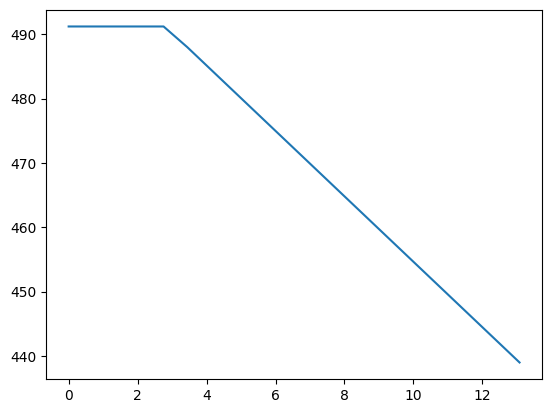

In [14]:
## plot pareto plot
objective1 =  'DM_HYDROGEN_PEROXIDE_cell'
objective2 =  'AraCore_Biomass_tx'#Arabidopsis_biomass_tx AraCore_Biomass_tx
solution_primary=pareto_analysis(core_model, objective1 = objective1, objective2=objective2, pareto_range = pareto_range, metric = metric)
#pd.DataFrame(result_list).to_excel('results.xlsx')
data=pd.DataFrame(solution_primary)
print(data)
plt.plot(data[1][:20],data[2][:20]) 
#plt.ylim([0.2152,0.2153])
#plt.xlim([0,0.03])
plt.show()###objs_rs=[AraCore_Biomass_tx 'Phloem_output_tx','DM_NITRIC-OXIDE_cell','DM_HS_cell','DM_SUPER_OXIDE_cell','DM_HC00250_cell','DM_CPD0-1395_cell','DM_SO3_cell','DM_CPD-12377_cell','DM_HYDROGEN_PEROXIDE_cell','DM_ho2_rad_cell']
